In [1]:
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from neural_network import *
from ensembling_methods import *
from figure_grid import *

# Use autograd to get easy manifold tangents; could also do this in Tensorflow but less conveniently.
import autograd.numpy as np
from autograd.scipy.special import expit
from autograd import elementwise_grad

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2D Manifold Example

In this notebook, we'll replicate the synthetic experiment from the appendix on a 2D manifold embedding in 3-dimensional space. This experiment illustrates a limitation of our method (when model differences in local extrapolation aren't meaningful, because we extrapolate away from the support of the data) and the basic strategy for resolving it (encourage different extrapolations on the manifold).

## Construct a random manifold (using a neural network)

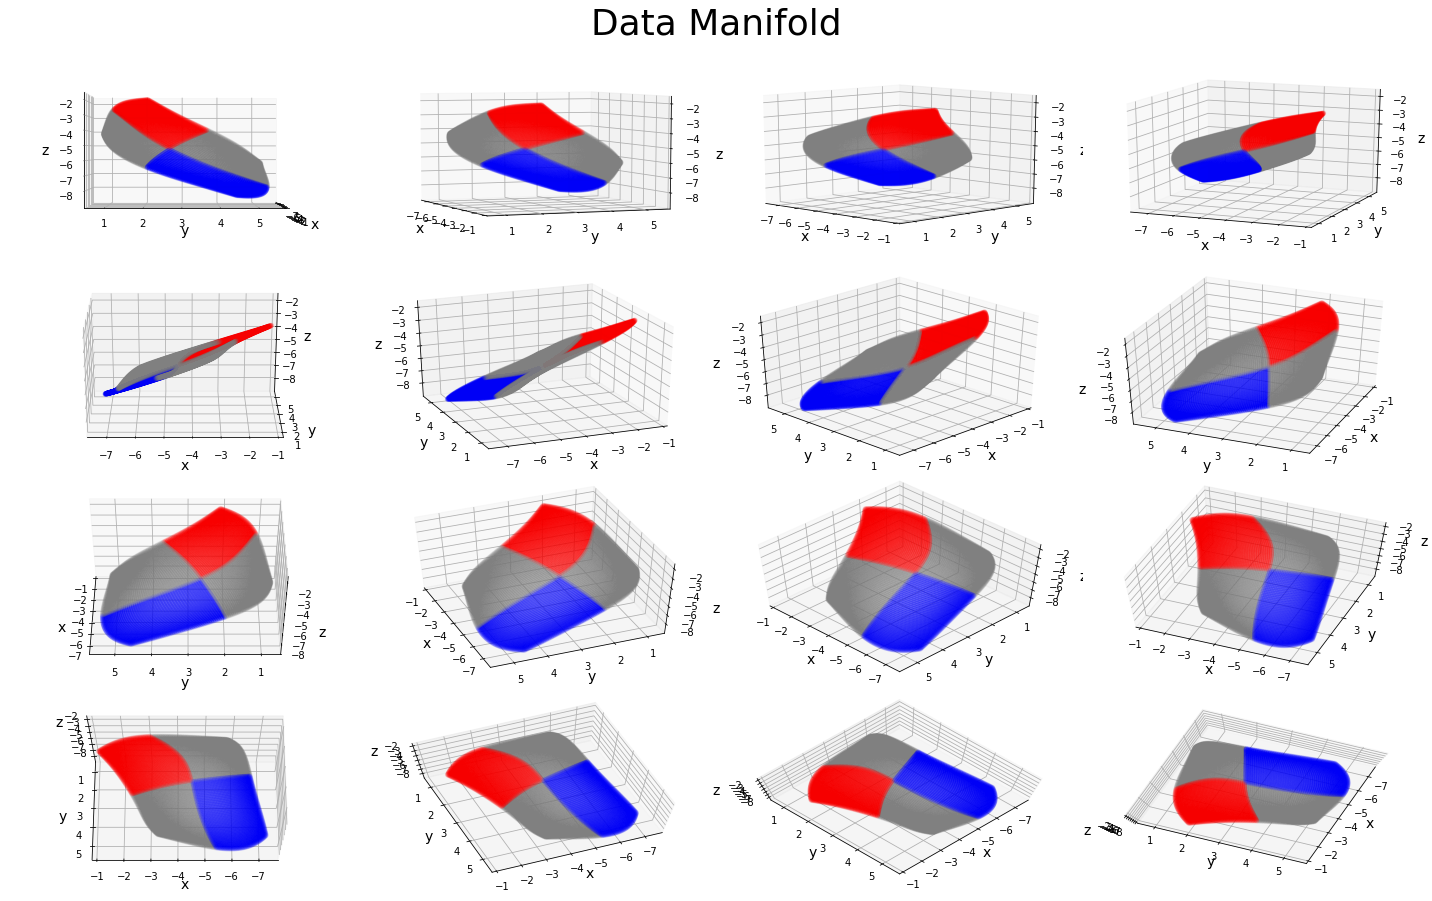

In [7]:
X_orig = np.array([
  [x,y] for x in np.linspace(-3,3,100) for y in np.linspace(-3,3,100)
])

W1 = np.random.normal(size=(3,100))*0.5
W2 = np.random.normal(size=(100,3))*0.5

manifold = lambda x: np.dot(expit(np.dot(np.hstack((x, np.ones((len(x),1)))), W1)), W2)

X_trans = manifold(X_orig)
trn = np.argwhere(np.product(X_orig,axis=1) > 0)[:,0]
tst = np.argwhere(np.product(X_orig,axis=1) <= 0)[:,0]
y1 = (X_orig[:,0] > 0).astype(float)
y2 = (X_orig[:,1] > 0).astype(float)
np.random.shuffle(trn)
np.random.shuffle(tst)

n_plots = 16

with figure_grid(4, n_plots/4, rowwidth=20, rowheight=3) as g:
  g.title("Data Manifold", fontsize=36)
  for i in range(n_plots):
    ax = g.next(projection='3d')
    ax.scatter(*X_trans[tst].T, c='grey', alpha=0.1)
    ax.scatter(*X_trans[trn].T, c=y1[trn], alpha=0.1, cmap='bwr')
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.set_zlabel('z', fontsize=14)
    ax.view_init(90*i/n_plots,-360*i/n_plots)
    
X_train = X_trans[trn]
y_train = y1[trn]

## Initialize network

In [8]:
class Net(NeuralNetwork):
  @property
  def x_shape(self): return [None, 3]
  @property
  def y_shape(self): return [None, 2]
  def rebuild_model(self, X, **_):
    L0 = X
    L1 = tf.layers.dense(L0, 256, name=self.name+'/L1', activation=tf.nn.softplus)
    L2 = tf.layers.dense(L1, 256, name=self.name+'/L2', activation=tf.nn.softplus)
    L3 = tf.layers.dense(L2,   2, name=self.name+'/L3', activation=None)
    return [L1, L2, L3]

We found that using softplus activations was a little bit more necessary here than in other experiments. Softplus activations make the neural network many-times differentiable, which may assist in minimizing a loss function that itself contains first derivatives.

## Compute manifold tangents

To make our penalty measure local correlation on the manifold, we will project our models' input gradients down to the manifold by taking dot products with the manifold's tangent space basis vectors. We'll compute these tangent space vectors using autograd for simplicity.

In [10]:
def manifold_tangent_space_projections(X_in, manifold):
  X_out = manifold(X_in)
  input_dim = X_in.shape[1]
  output_dim = X_out.shape[1]
  return np.stack([
    elementwise_grad(lambda x: manifold(x)[:,i])(X_in)
    for i in range(output_dim)], -1)

manifold_projections = manifold_tangent_space_projections(X_orig[trn], manifold)

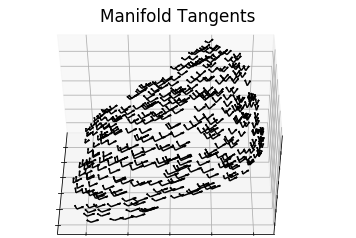

In [22]:
def view(ax):
  n_plots = 16
  i = 8
  ax.view_init(90*i/float(n_plots),-360*i/float(n_plots))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticklabels([])
  ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.15, 1.15, 1.15, 1]))

full_manifold_projections = manifold_tangent_space_projections(X_orig, manifold)
idx = np.arange(len(X_orig))
np.random.shuffle(idx)
idx = idx[::25]

ax = plt.subplot(111,title='Manifold Tangents',projection='3d')
ax.quiver(*X_trans[idx].T, *full_manifold_projections[idx].T, length=0.25, color='black')
view(ax)
plt.show()

## Train three variants of models: restarts, input-space LIT, and tangent-space LIT

Now that we've determined the manifold tangent space, we can train the variants of our model:

In [11]:
tf.reset_default_graph()

print("train restarts")
random_restart_models = train_restart_models(Net, 2, X_train, y_train, num_epochs=100, print_every=250)

print("train input-space LIT")
input_space_models = train_diverse_models(Net, 2, X_train, y_train,
                                          num_epochs=100, print_every=250)

print("train tangent-space LIT")
tangent_space_models = train_diverse_models_w_projection(Net, 2, X_train, y_train, manifold_projections,
                                                         num_epochs=100, print_every=250)

train restarts
Batch 0, epoch 0, time 0.2s, accu 0.5820, loss 1.0382, xent 1.0382
Batch 250, epoch 12, time 1.2s, accu 1.0000, loss 0.0076, xent 0.0076
Batch 500, epoch 25, time 2.1s, accu 1.0000, loss 0.0012, xent 0.0012
Batch 750, epoch 37, time 3.0s, accu 1.0000, loss 0.0033, xent 0.0033
Batch 1000, epoch 50, time 4.0s, accu 1.0000, loss 0.0003, xent 0.0003
Batch 1250, epoch 62, time 4.9s, accu 1.0000, loss 0.0022, xent 0.0022
Batch 1500, epoch 75, time 5.8s, accu 1.0000, loss 0.0001, xent 0.0001
Batch 1750, epoch 87, time 6.7s, accu 1.0000, loss 0.0020, xent 0.0020
Batch 0, epoch 0, time 0.4s, accu 0.5820, loss 0.7068, xent 0.7068
Batch 250, epoch 12, time 1.2s, accu 1.0000, loss 0.0062, xent 0.0062
Batch 500, epoch 25, time 2.1s, accu 1.0000, loss 0.0008, xent 0.0008
Batch 750, epoch 37, time 2.9s, accu 1.0000, loss 0.0027, xent 0.0027
Batch 1000, epoch 50, time 3.8s, accu 1.0000, loss 0.0002, xent 0.0002
Batch 1250, epoch 62, time 4.7s, accu 1.0000, loss 0.0022, xent 0.0022
Batch

## Plot model decision boundaries over $\mathbb{R}^3$ and the original 2D chart space

In [13]:
def contour(f, lines=[0.5], linewidths=8, alpha=0.9, **kw):
  grid = np.linspace(-3.5, 3.5, 150)
  xg, yg = np.meshgrid(grid, grid)
  zg = griddata(X_orig[:,0], X_orig[:,1], f, grid, grid, interp='linear')
  plt.contour(xg, yg, zg, lines, linewidths=linewidths, alpha=0.8, **kw)
  plt.xlim(-3.5,3.5)
  plt.ylim(-3.5,3.5)

In [14]:
fullspace = np.array([[x,y,z]
                      for x in np.linspace(X_trans[:,0].min()-0.5, X_trans[:,0].max()+0.5, 60)
                      for y in np.linspace(X_trans[:,1].min()-0.5, X_trans[:,1].max()+0.5, 60)
                      for z in np.linspace(X_trans[:,2].min()-0.5, X_trans[:,2].max()+0.5, 60)])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  after removing the cwd from sys.path.


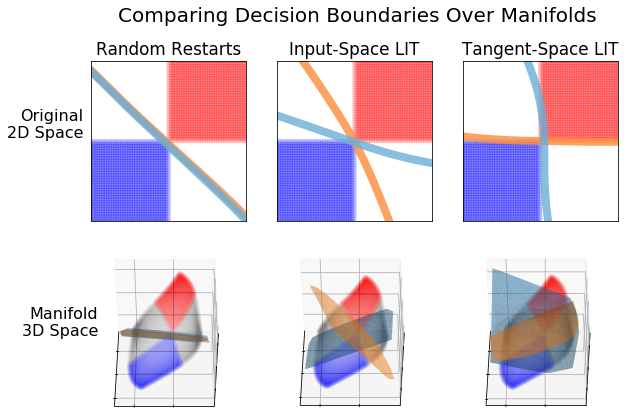

In [16]:
plt.rcParams.update({'font.size': 14})

with figure_grid(2,3,rowheight=2.75, rowwidth=8) as g:
  g.title("Comparing Decision Boundaries Over Manifolds", fontsize=20)
  
  for ens, title in zip([random_restart_models, input_space_models, tangent_space_models],
                        ['Random Restarts', 'Input-Space LIT', 'Tangent-Space LIT']):
    preds1 = ens[0].predict_proba(X_trans)[:,1]
    preds2 = ens[1].predict_proba(X_trans)[:,1]
  
    g.next()
    plt.title(title)
    plt.scatter(*X_orig[tst].T, c='grey', alpha=0.001)
    plt.scatter(*X_orig[trn].T, c=y1[trn], alpha=0.1, cmap='bwr')
    contour(preds1, alpha=1.0, cmap='Oranges', vmin=0, vmax=1)
    contour(preds2, alpha=1.0, cmap='Blues', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    
  for ens, title in zip([random_restart_models, input_space_models, tangent_space_models],
                        ['Random Restarts', 'Input-Space LIT', 'Tangent-Space LIT']):
    preds1 = ens[0].predict_proba(fullspace)[:,1]
    preds2 = ens[1].predict_proba(fullspace)[:,1]
  
    ax = g.next(projection='3d')
    ax.scatter(*X_trans[tst].T, c='grey', alpha=0.005)
    ax.scatter(*X_trans[trn].T, c=y1[trn], alpha=0.01, cmap='bwr')
    
    pts = np.argwhere(np.abs(preds1 - 0.5) < 0.005)[:,0]
    ax.plot_trisurf(*fullspace[pts].T, alpha=0.5)
    
    pts = np.argwhere(np.abs(preds2 - 0.5) < 0.005)[:,0]
    ax.plot_trisurf(*fullspace[pts].T, alpha=0.5)
    
    view(ax)
    
  g.fig.text(0.025, 0.75, 'Original\n2D Space',  fontsize=16, rotation=0, va='center', ha='right')
  g.fig.text(0.05, 0.25, 'Manifold\n3D Space',  fontsize=16, rotation=0, va='center', ha='right')

While LIT in input space can produce somewhat different boundaries over the manifold, we achieve greater diversity with the LIT penalty defined in the basis of the manifold's tangent vectors.